In [1]:
# 필요한 라이브러리 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import numpy as np
import pandas as pd
import os

from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}') # Device: cuda(A5000)
!nvidia-smi

/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/billy/anaconda3/envs/llama2-7b/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

Device: cuda
Fri Nov 29 10:55:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 45%   66C    P0             99W /  230W |     242MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [ ]:
# 그래프 한글 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

hasKoreanFont = len(
    [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]) > 0
if hasKoreanFont:
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
from sklearn.model_selection import train_test_split


def load_data(data_path: str) -> pd.DataFrame:
    df = pd.read_excel(data_path,
                       usecols=['발명의 명칭', '요약', '메인IPC2', '대표청구항'])
    df['input'] = df.apply(
        lambda row: f"{row['발명의 명칭']}\n\n{row['요약']}", axis=1)
    df = df.drop(columns=['발명의 명칭', '요약', '대표청구항'])
    df.columns = ['메인IPC2', '대표청구항']
    return df


# 훈련 데이터 로드
xlsx_path_train = '/home/billy/rd/dataset/DS학술제-모델링경진대회_Train.xlsx'
df_train = load_data(xlsx_path_train)

# 테스트 데이터 로드
xlsx_path_test = '/home/billy/rd/dataset/DS학술제-모델링경진대회_Valid.xlsx'
df_test = load_data(xlsx_path_test)


# 레이블 인코딩 (훈련 데이터 기준)
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['메인IPC2'])

# 레이블과 인코딩된 값 출력
print("레이블 인코딩 결과:")
for label, index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {index}")  # G06F: 0, G06Q: 1, G16H: 2

# 테스트 데이터의 레이블을 동일한 인코더로 변환
# 테스트 데이터에 훈련 데이터에 없는 레이블이 있을 경우 처리 필요
unseen_labels = set(df_test['메인IPC2']) - set(label_encoder.classes_)

if unseen_labels:
    print("주의: 테스트 데이터셋에 훈련 데이터셋에 없는 레이블이 있습니다. 해당 샘플을 제거합니다.")
    print(f"제거될 레이블: {unseen_labels}")
    # 테스트 데이터셋에서 해당 샘플 제거
    df_test = df_test[~df_test['메인IPC2'].isin(
        unseen_labels)].reset_index(drop=True)

# 테스트 데이터 레이블 변환
df_test['label'] = label_encoder.transform(df_test['메인IPC2'])

# 텍스트와 레이블 추출
train_texts_full = df_train['대표청구항']
train_labels_full = df_train['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_full, train_labels_full, test_size=0.1, random_state=42, stratify=train_labels_full
)

test_texts = df_test['대표청구항']
test_labels = df_test['label']

레이블 인코딩 결과:
G06F: 0
G06Q: 1
G16H: 2


In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("monologg/kobert", config=AutoConfig.from_pretrained(
    "monologg/kobert",
    num_labels=len(label_encoder.classes_),
    output_hidden_states=True
))
tokenizer = AutoTokenizer.from_pretrained(
    "monologg/kobert", trust_remote_code=True)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
# 커스텀 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 텍스트를 토크나이즈하고 텐서로 변환
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }


# 데이터로더 생성
# 훈련 데이터셋
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 검증 데이터셋
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 테스트 데이터셋 (별도 파일에서 로드한 데이터)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# 옵티마이저와 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 손실 함수 정의 (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss().to(device)

# 학습 함수 정의


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()

    losses = []
    correct_preds = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
        optimizer.step()
        scheduler.step()

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses)

# 평가 함수 정의


def eval_model(model, data_loader, loss_fn, device):
    model.eval()

    losses = []
    correct_preds = 0
    predictions = []
    true_labels = []
    all_features = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            features = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            all_features.extend(features)

            _, preds = torch.max(logits, dim=1)
            correct_preds += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses), predictions, true_labels, all_features

In [ ]:
EPOCHS = 5  # 에폭 수

for epoch in range(EPOCHS):
    print(f'에폭 {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )

    print(f'훈련 손실 {train_loss:.4f}, 정확도 {train_acc:.4f}')

    val_acc, val_loss, train_y_pred, train_y_true, all_features = eval_model(
        model,
        val_loader,
        loss_fn,
        device
    )

    print(f'검증 손실 {val_loss:.4f}, 정확도 {val_acc:.4f}')

에폭 1/5
----------
훈련 손실 0.5615, 정확도 0.7822
검증 손실 0.3478, 정확도 0.8755
에폭 2/5
----------
훈련 손실 0.3374, 정확도 0.8807
검증 손실 0.4631, 정확도 0.8299
에폭 3/5
----------
훈련 손실 0.2603, 정확도 0.9117
검증 손실 0.3006, 정확도 0.8838
에폭 4/5
----------
훈련 손실 0.1510, 정확도 0.9552
검증 손실 0.3039, 정확도 0.9046
에폭 5/5
----------
훈련 손실 0.1013, 정확도 0.9727
검증 손실 0.3196, 정확도 0.8963


In [8]:
# 모델 저장
from datetime import datetime

cur_time_str = datetime.now().strftime("%Y%m%d%H%M%S")
model_save_path = f'model_{cur_time_str}/'


model.save_pretrained(model_save_path)
print("Model saved successfully.")

Model saved successfully.


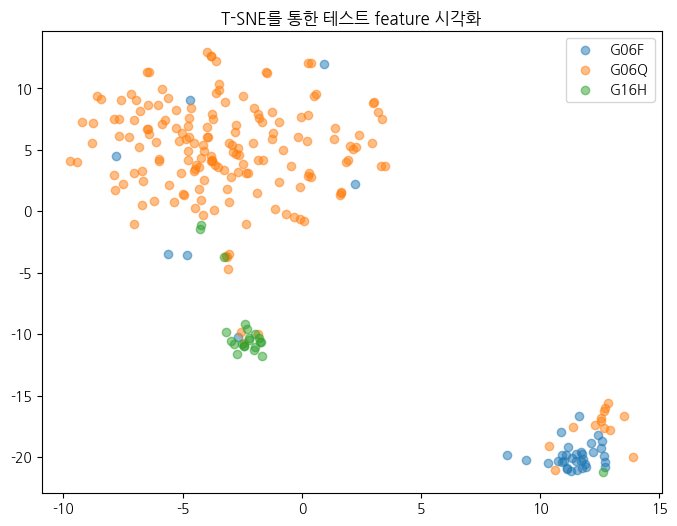

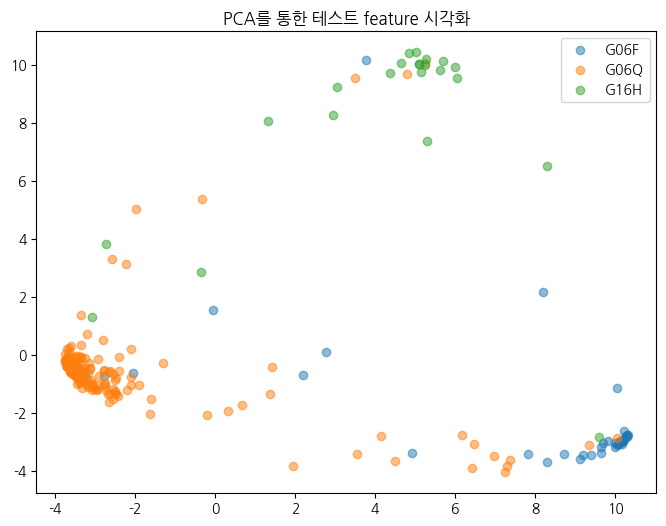

In [ ]:

# 클래스 간 feature 분포 시각화
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def plot_feature_distribution(features, y_true, label_encoder):
    # feature와 레이블을 numpy 배열로 변환
    features_array = np.array(features)
    labels_array = np.array(y_true)

    # T-SNE 시각화
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features_array)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels_array):
        idx = labels_array == label
        plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1],
                    label=label_encoder.inverse_transform([label])[0], alpha=0.5)
    plt.legend()
    plt.title('T-SNE를 통한 테스트 feature 시각화')
    plt.show()

    # PCA 시각화
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_array)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels_array):
        idx = labels_array == label
        plt.scatter(features_pca[idx, 0], features_pca[idx, 1],
                    label=label_encoder.inverse_transform([label])[0], alpha=0.5)
    plt.legend()
    plt.title('PCA를 통한 테스트 feature 시각화')
    plt.show()


plot_feature_distribution(all_features, train_y_true, label_encoder)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_save_path, num_labels=len(label_encoder.classes_))
model.to(device)

# 테스트 데이터에서 모델 평가
test_acc, test_loss, y_pred, y_true, test_features = eval_model(
    model,
    test_loader,
    loss_fn,
    device
)

print(f'테스트 손실 {test_loss:.4f}, 정확도 {test_acc:.4f}')

# 분류 리포트 생성 (정밀도, 재현율 등)
print('\n분류 리포트:')
print(classification_report(y_true, y_pred,
      target_names=label_encoder.classes_, digits=4))

테스트 손실 0.4181, 정확도 0.8688

분류 리포트:
              precision    recall  f1-score   support

        G06F     0.7009    0.7576    0.7282        99
        G06Q     0.9295    0.9129    0.9212       448
        G16H     0.7091    0.7091    0.7091        55

    accuracy                         0.8688       602
   macro avg     0.7799    0.7932    0.7861       602
weighted avg     0.8718    0.8688    0.8701       602



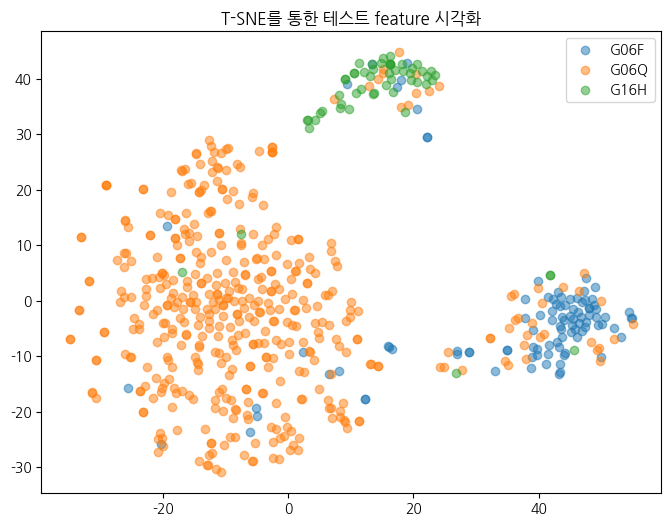

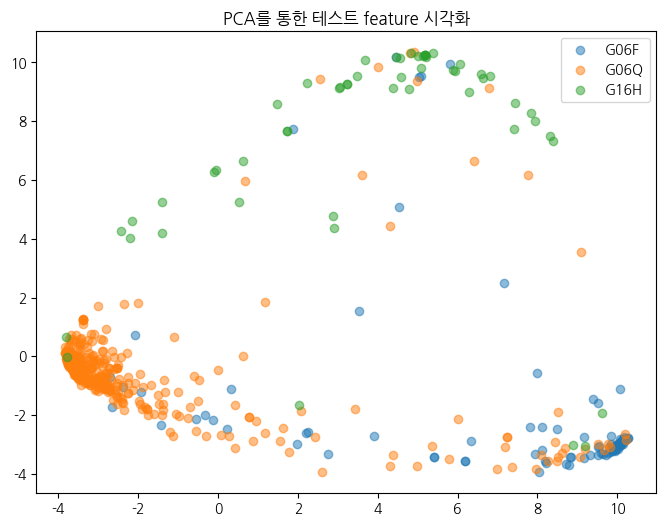

In [ ]:
# 클래스 간 feature 분포 시각화
plot_feature_distribution(test_features, y_true, label_encoder)